#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 11
**CH11A Does Smoking Pose a Health Risk?**

using the share-health dataset

version 1.0 2021-05-05 (modified 02.12.2023)

## Recap theory
### Linear probability model
-> **linear** models with **binary y**

$y^P = \beta_0 + \beta_1x_1 + \beta_2x_2 + \dots$

- $\beta_0$: probability that y=1 for observations where all variables=0
- $\beta_1$: by how much probability of y=1 is higher for observations with 1 unit higher $x_1$, the rest constant
- $\beta_2$: by how much probability of y=1 is higher for observations with 1 unit higher $x_2$, the rest constant
- $\dots$

-> main issue: the estimated probabilities are not restricted between 0 and 1 (problem for prediction, not for simply uncovering associations)

## Case study
Question: whether and by how much smokers are less likely to stay healthy, compared to nonsmokers

Dataset: SHARE longitudinal survey (across European countries), wave 4 (2011) and wave 6 (2015) of people between 50-60 in 2011
- Focus on people of age 50 to 60 who consider themselves healthy (in 2011)
- Ask them four years later as well (2015)

### Set up

In [64]:
import os
from pathlib import Path
import sys
import warnings

import numpy as np
import pandas as pd
from mizani.formatters import percent_format
from plotnine import *
from scipy.stats import logistic
from scipy.stats import norm
from stargazer.stargazer import Stargazer
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import log_loss

warnings.filterwarnings("ignore")


In [65]:
path = Path(os.getcwd())

base_dir = path.parent.parent

data_in = os.path.join(str(base_dir), "TAsessions/da_data_repo/share-health/clean/")
data_out = os.path.join(str(base_dir), "TAsessions/ch11-smoking-health-risk/")
output = os.path.join(str(base_dir), "TAsessions/ch11-smoking-health-risk/output/")
func = os.path.join(str(base_dir), "TAsessions/ch00-tech-prep/")


In [66]:
sys.path.append(func)

from py_helper_functions import *


In [168]:
share = pd.read_csv(os.path.join(data_in, "share-health.csv"))


# Part I – create workfile

1. create variable healthy

In [169]:
share["healthy"] = 0
share.loc[(share["sphus"] == 1) | (share["sphus"] == 2), "healthy"] = 1 # healthy=1 
share.loc[~((share["sphus"] > 0) & (share["sphus"] <= 5)), "healthy"] = np.nan

In [170]:
share.head(5)

,mergeid,wave,country,country_mod,int_year,int_month,female,age,eduyears_mod,sphus,br015,smoking,ever_smoked,income_pct_w4,bmi,mar_stat,healthy
0,AT-000327-01,1,11,40,2004,6,0,51.900002,-15.0,1,2,5,5,-13,32.787994,1,1.0
1,AT-000327-01,2,11,40,2007,3,0,54.700001,-3.0,5,4,5,5,-13,20.281233,1,0.0
2,AT-000327-02,1,11,40,2004,6,1,48.900002,3.0,1,3,5,5,-13,31.161373,1,1.0
3,AT-000327-02,2,11,40,2007,3,1,51.700001,3.0,2,1,5,5,-13,30.461119,1,1.0
4,AT-000674-01,4,11,40,2011,11,1,59.700001,3.0,3,1,5,5,1,24.023809,6,0.0


In [171]:
share["healthy"].value_counts()


healthy
0.0    213847
1.0     73808
Name: count, dtype: int64

In [172]:
share = share.dropna(how="any")


2. Keep 2 waves
3. 2011 = baseline, 2015 = endline

In [173]:
share["baseline"] = 0
share.loc[share["wave"] == 4, "baseline"] = 1
share["endline"] = 0
share.loc[share["wave"] == 6, "endline"] = 1


In [174]:
share["baseline"].value_counts()


baseline
0    229773
1     57882
Name: count, dtype: int64

In [175]:
share["endline"].value_counts()


endline
0    219568
1     68087
Name: count, dtype: int64

4. if observation at endline and healthy, temp=1; if endline but not healthy, temp=0; otherwise NaN

In [179]:
share["temp"] = np.where(
    share["endline"] == 1, np.where(share["healthy"] == 1, 1, 0), np.nan
)


In [180]:
share["temp"].value_counts()

temp
0.0    51241
1.0    16846
Name: count, dtype: int64

In [181]:
share.head(20)

,mergeid,wave,country,country_mod,int_year,int_month,female,age,eduyears_mod,sphus,br015,smoking,ever_smoked,income_pct_w4,bmi,mar_stat,healthy,baseline,endline,temp
0,AT-000327-01,1,11,40,2004,6,0,51.900002,-15.0,1,2,5,5,-13,32.787994,1,1.0,0,0,NaN
1,AT-000327-01,2,11,40,2007,3,0,54.700001,-3.0,5,4,5,5,-13,20.281233,1,0.0,0,0,NaN
2,AT-000327-02,1,11,40,2004,6,1,48.900002,3.0,1,3,5,5,-13,31.161373,1,1.0,0,0,NaN
3,AT-000327-02,2,11,40,2007,3,1,51.700001,3.0,2,1,5,5,-13,30.461119,1,1.0,0,0,NaN
4,AT-000674-01,4,11,40,2011,11,1,59.700001,3.0,3,1,5,5,1,24.023809,6,0.0,1,0,NaN
5,AT-000674-01,5,11,40,2013,10,1,61.599998,3.0,3,1,5,5,-13,25.402817,6,0.0,0,0,NaN
6,AT-000674-01,6,11,40,2015,6,1,63.299999,3.0,3,3,5,5,-13,27.636055,6,0.0,0,1,0.0
7,AT-001215-01,4,11,40,2011,10,1,72.599998,15.0,3,1,1,1,2,29.065928,4,0.0,1,0,NaN
8,AT-001215-01,5,11,40,2013,5,1,74.199997,15.0,4,4,1,1,-13,29.065928,4,0.0,0,0,NaN
9,AT-001215-01,6,11,40,2015,3,1,76.000000,15.0,4,1,-15,1,-13,28.075043,4,0.0,0,1,0.0


5. stayhealthy merges the information on temp based on the id (1 if the same individual as reported healthy=1 in both waves, 0 if from healthy=1 in wave 4 to healthy=0 in wave 6, NaN otherwise)

In [182]:
share["stayshealthy"] = share.groupby("mergeid")["temp"].transform(np.nanmax)


In [183]:
share.head(5)

,mergeid,wave,country,country_mod,int_year,int_month,female,age,eduyears_mod,sphus,...,smoking,ever_smoked,income_pct_w4,bmi,mar_stat,healthy,baseline,endline,temp,stayshealthy
0,AT-000327-01,1,11,40,2004,6,0,51.900002,-15.0,1,...,5,5,-13,32.787994,1,1.0,0,0,NaN,NaN
1,AT-000327-01,2,11,40,2007,3,0,54.700001,-3.0,5,...,5,5,-13,20.281233,1,0.0,0,0,NaN,NaN
2,AT-000327-02,1,11,40,2004,6,1,48.900002,3.0,1,...,5,5,-13,31.161373,1,1.0,0,0,NaN,NaN
3,AT-000327-02,2,11,40,2007,3,1,51.700001,3.0,2,...,5,5,-13,30.461119,1,1.0,0,0,NaN,NaN
4,AT-000674-01,4,11,40,2011,11,1,59.700001,3.0,3,...,5,5,1,24.023809,6,0.0,1,0,NaN,0.0


In [184]:
share["stayshealthy"].value_counts()


stayshealthy
0.0    148453
1.0     46718
Name: count, dtype: int64

In [185]:
share = share.drop("temp", axis=1)


6. Drop observations 

In [187]:
# keep if endline health outcome non-missing
share = share.loc[lambda x: (x["stayshealthy"] == 1) | (x["stayshealthy"] == 0)]


In [188]:
# keep baseline observations (endline outcome already defined for them)
share = share.loc[lambda x: x["baseline"] == 1]


In [189]:
# keep age 50-60 at baseline
share = share.loc[lambda x: (x["age"] >= 50) & (x["age"] <= 60)]


In [190]:
# keep healthy individuals at baseline
share = share.loc[lambda x: x["healthy"] == 1]


In [191]:
# keep those with non-missing observations for smoking at baseline
# and re-define smoking to be 0-1
share.loc[lambda x: x["smoking"] == 5, "smoking"] = 0
share = share.loc[lambda x: (x["smoking"] == 0) | (x["smoking"] == 1)]

share.loc[lambda x: x["ever_smoked"] == 5, "ever_smoked"] = 0
share = share.loc[lambda x: (x["ever_smoked"] == 0) | (x["ever_smoked"] == 1)]


We have 3271 individuals

Exercise, BMI, Married, Years of Education - keep only observations with non-missing values

In [192]:
share["exerc"] = np.where(
    share["br015"] == 1,
    1,
    np.where((share["br015"] > 0) & (share["br015"] != 1), 0, np.nan),
)
share["exerc"].value_counts()


exerc
1.0    1702
0.0    1569
Name: count, dtype: int64

In [193]:
share["bmi"] = np.where(share["bmi"] < 0, np.nan, share["bmi"])

share["bmi"].describe().round(2)


count    3197.00
mean       25.54
std         3.90
min        16.33
25%        22.84
50%        25.10
75%        27.77
max        45.63
Name: bmi, dtype: float64

In [194]:
share = share.rename(columns={"income_pct_w4": "income10"})


In [195]:
share["married"] = np.where((share["mar_stat"] == 1) | (share["mar_stat"] == 2), 1, 0)


In [196]:
share["eduyears"] = np.where(share["eduyears_mod"] < 0, np.nan, share["eduyears_mod"])

share["eduyears"].describe().round(2)


count    3184.00
mean       12.31
std         4.57
min         0.00
25%        10.00
50%        12.00
75%        16.00
max        25.00
Name: eduyears, dtype: float64

In [197]:
share = share.drop("eduyears_mod", axis=1)


In [198]:
share = share.loc[
    lambda x: (x["bmi"].notnull()) & (x["eduyears"].notnull()) & (x["exerc"].notnull())
]


In [199]:
share.filter(
    [
        "stayshealthy",
        "smoking",
        "ever_smoked",
        "female",
        "age",
        "income10",
        "eduyears",
        "bmi",
        "exerc",
    ]
).describe().round(2)


,stayshealthy,smoking,ever_smoked,female,age,income10,eduyears,bmi,exerc
count,3109.00,3109.00,3109.00,3109.00,3109.00,3109.00,3109.00,3109.00,3109.00
mean,0.60,0.22,0.49,0.56,55.19,6.79,12.33,25.53,0.52
std,0.49,0.42,0.50,0.50,2.79,2.75,4.56,3.91,0.50
min,0.00,0.00,0.00,0.00,50.00,1.00,0.00,16.33,0.00
25%,0.00,0.00,0.00,0.00,52.80,5.00,10.00,22.84,0.00
50%,1.00,0.00,0.00,1.00,55.30,7.00,13.00,25.10,1.00
75%,1.00,0.00,1.00,1.00,57.50,9.00,16.00,27.77,1.00
max,1.00,1.00,1.00,1.00,60.00,10.00,25.00,45.63,1.00


- Observations: 3109
- 60% stayed healthy
- 22% where smokers in 2011
- 49% ever smoked

In [200]:
pd.crosstab(share["country"], share["stayshealthy"])


stayshealthy,0.0,1.0
country,,
11,118,254
12,21,24
13,25,55
15,82,92
16,123,86
17,135,166
18,73,322
20,131,309
23,173,265


14 countries

In [201]:
share.reset_index(drop=True).to_csv("ch11_share.csv")


#  2. PART - SIMPLE LPM MODELS

In [202]:
share = pd.read_csv("ch11_share.csv", index_col=0)


In [203]:
share.head()


,mergeid,wave,country,country_mod,int_year,int_month,female,age,sphus,br015,...,income10,bmi,mar_stat,healthy,baseline,endline,stayshealthy,exerc,married,eduyears
0,AT-001492-02,4,11,40,2011,9,0,59.799999,2,3,...,8,23.198315,1,1.0,1,0,1.0,0.0,1,13.0
1,AT-002136-03,4,11,40,2011,8,1,58.200001,1,2,...,9,24.801588,1,1.0,1,0,1.0,0.0,1,14.0
2,AT-002800-01,4,11,40,2011,9,1,57.000000,2,4,...,3,22.038567,3,1.0,1,0,1.0,0.0,0,23.0
3,AT-009262-02,4,11,40,2011,12,0,59.299999,2,1,...,6,25.826447,1,1.0,1,0,0.0,1.0,1,12.0
4,AT-009376-01,4,11,40,2011,9,0,53.299999,2,1,...,8,26.827421,1,1.0,1,0,0.0,1.0,1,3.0


**Model 1**: estimate linear probability model
- being healthy in 2015 (*stayhealthy*) as the binary dependent variable 
- smoker in 2011 as explanatory variable (*smoking*)

In [97]:
lpm1 = smf.ols("stayshealthy ~ smoking", data=share).fit(cov_type="HC1")

**Model 2**: include *ever_smoked*

In [98]:
lpm2 = smf.ols("stayshealthy ~ smoking + ever_smoked", data=share).fit(covtype="HC1")


### Table 11.1 Probability of staying healthy

In [99]:
stargazer = Stargazer([lpm1, lpm2])
stargazer.covariate_order(["smoking", "ever_smoked", "Intercept"])
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer


In [204]:
lpm1.conf_int(alpha=0.01)

,0,1
Intercept,0.594934,0.645845
smoking,-0.124953,-0.015251


**Model 1**: $stayhealthy^P=\alpha+\beta smoking$
- $\alpha$: 62% of non-smokers ($smoking=0$) stayed healthy
- $\beta$: smokers were 7% less likely to stay healthy
> 62-7=55% of smokers stayed healthy

estimates are statistically significant at 1%
- statistically different from 0, so we can be 99% confident that smokers are less likely to stay healthy in the population (represented by the dataset)
- we can be 99% confident that the smokers in the population (represented by the dataset) stay healthy with a lower probability of 1.5 to 12.5 percentage points

Note - population: 50-60-year-old people, from 14 European countries, who consider themselves healthy

**Model 2**: $stayhealthy^P=\beta_0+\beta_1 smoking +\beta_2 ever\_smoked$
- $\beta_1$: difference in probability of staying healthy between current smokers and non-current smokers who have same value in $ever\_smoked$ variable
> but for those who never smoked ($ever\_smoked=0$) we cannot make this comparison because $smoking=0$ always

-> current smokers were 7.9% less likely to stay healthy than those that used to smoke but quit

-> statistically significant at 1%, generalizable to the population

-$\beta_2$: compare people with same current smoking status, but different past past smoking status
 > comparison between current non-smokers ($smoking=0$)
 
-> those who used to smoke but quit are 1.4% more likely to stay healthy compared to those who never smoked

-> not statistically significant, cannot reject the null hp that in the population this coefficient is 0

### Figure 11.1 Staying healthy and smoking – scatterplot and regression line

We want to show the scatterplot and the regression line that correspond to **Model 1**

1. predicted values to visualize the regression line

In [205]:
share["pred1"] = lpm1.predict()

pd.crosstab(index=share["pred1"], columns=share["smoking"])


smoking,0,1
pred1,,
0.550287,0,696
0.620390,2413,0


In [206]:
pd.crosstab(index=share["stayshealthy"], columns=share["smoking"])


smoking,0,1
stayshealthy,,
0.0,916,313
1.0,1497,383


In [207]:
share["weight"] = share.groupby(["smoking", "stayshealthy"])["smoking"].transform(len)
share["weight_2"] = share["weight"] / 1000
# size of the dot
#group by if current smokers or not, if stayed healthy or not
#find lenght = frequency

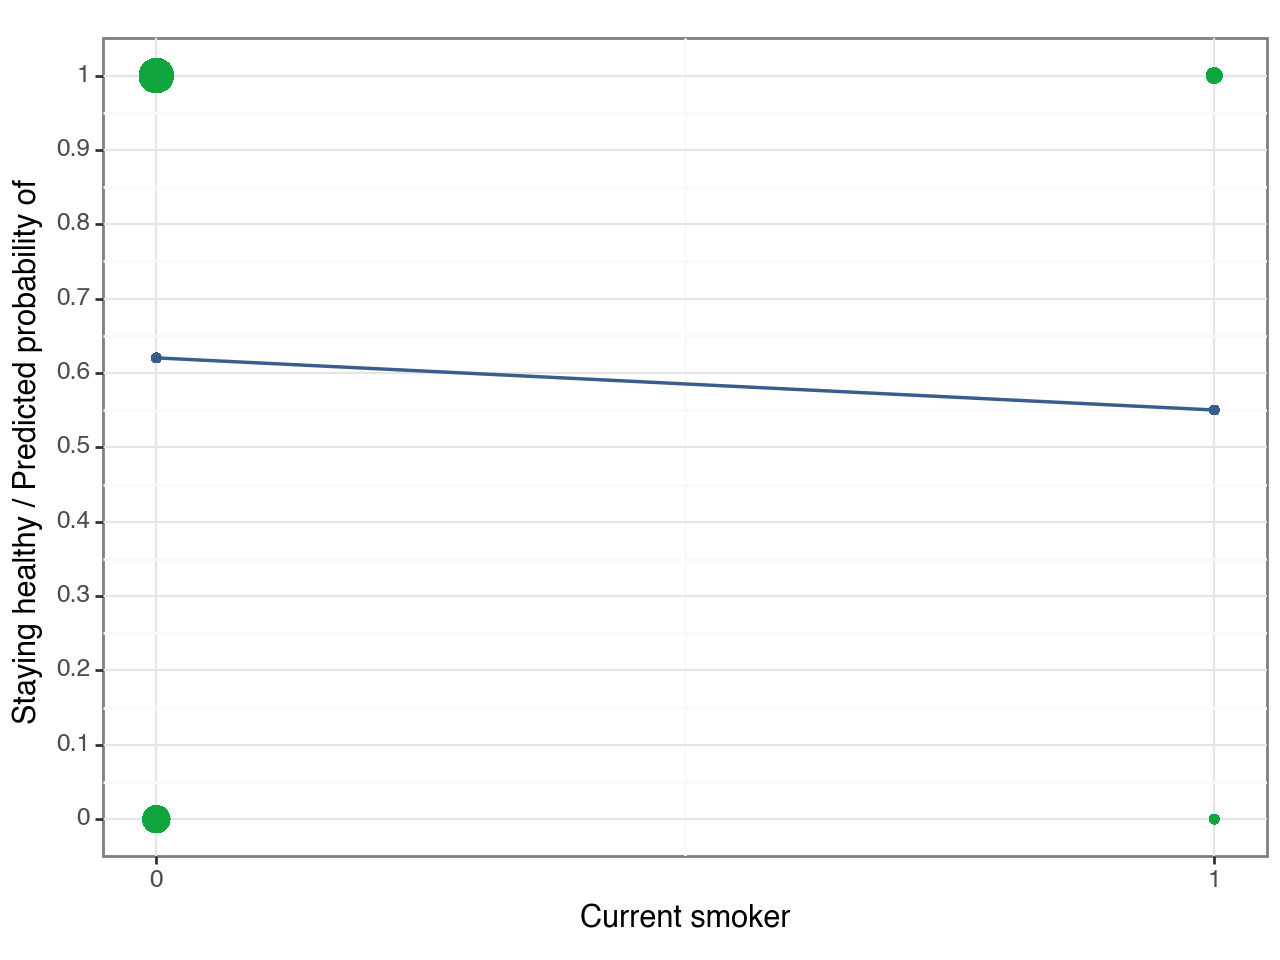

<Figure Size: (640 x 480)>

In [208]:
g1 = (
    ggplot(data=share)
    + geom_point(aes(x="smoking", y="pred1"), size=1, color=color[0])
    + geom_line(aes(x="smoking", y="pred1"), colour=color[0], size=0.7)
    + geom_point(
        aes(x="smoking", y="stayshealthy", size="weight_2"),
        fill=color[1],
        color=color[1],
        alpha=0.8,
        show_legend=False,
    )
    + labs(x="Current smoker", y="Staying healthy / Predicted probability of ")
    + coord_cartesian(xlim=[0, 1], ylim=[0, 1])
    + scale_y_continuous(limits=[0, 1], breaks=seq(0, 1, 0.1))
    + scale_x_continuous(limits=[0, 1], breaks=seq(0, 1, 1))
    + theme_bw()
)
g1

All data points are in one of the four corners because both the depedent and the explanatory variable are binary. 

Size of the dot is proportional to the frequency in the data

The regression line connects the two predicted probabilities: the fraction that stayed healthy among nonsmokers and the 7pp lower fraction among smokers 

In [209]:
share["weight"] = (
    share.groupby(["eduyears", "stayshealthy"])["smoking"].transform(len) / 100
)
# can do the same with years of educ

Now we want to condition on other observable characteristics: 
- gender (binary)
- age, 
- years of education, 
- income (measured as 10 income groups in each country), 
- bmi
- excercise regularly (binary)
- country (binary indicators), see below

### Figure 11.2 Education, income, and the probability of staying healthy – non-parametric regressions

We examine 3 lowess regressions to decide what functional forms to include
- staying healthy and years of education
- staying healthy and income group
- staying healthy and age
- staying healthy and bmi

(a) Staying healthy and years of education

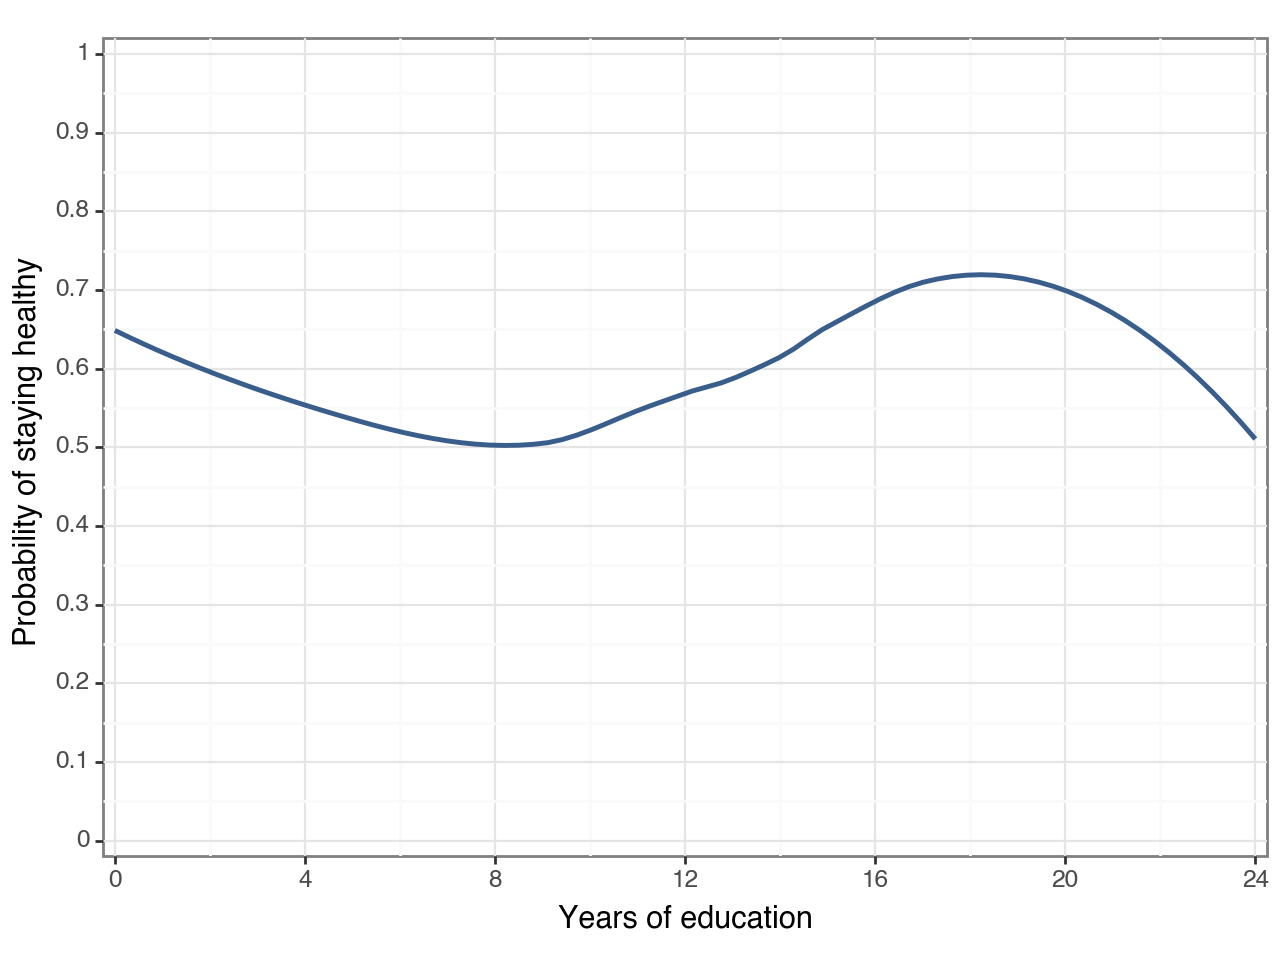

<Figure Size: (640 x 480)>

In [210]:
g2 = (
    ggplot(data=share)
    + geom_smooth(
        aes(x="eduyears", y="stayshealthy"), method="loess", se=False, color=color[0]
    )
    + labs(x="Years of education", y="Probability of staying healthy ")
    # + coord_cartesian(xlim = [0, 1], ylim=[0,1])
    + scale_x_continuous(expand=[0.01, 0.01], limits=[0, 24], breaks=seq(0, 24, 4))
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 1], breaks=seq(0, 1, 0.1))
    + theme_bw()
)
g2


knots at 8 and 18

-> include education as a piecewise linear spline with these knots

(b) Staying healthy and income group

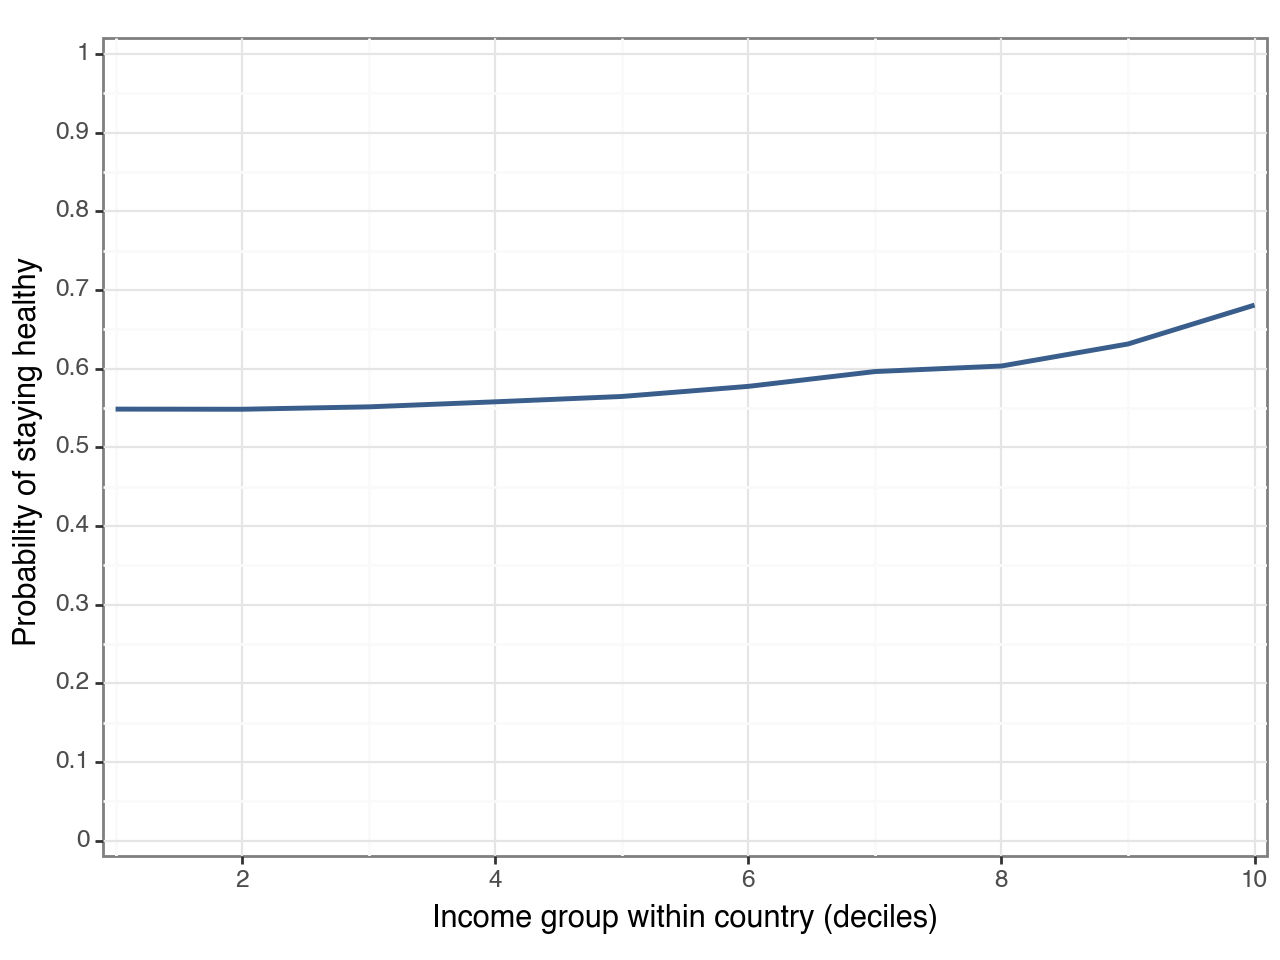

<Figure Size: (640 x 480)>

In [211]:
g2b = (
    ggplot(data=share)
    + geom_smooth(
        aes(x="income10", y="stayshealthy"), method="loess", se=False, color=color[0]
    )
    + labs(
        x="Income group within country (deciles)", y="Probability of staying healthy "
    )
    + scale_x_continuous(expand=[0.01, 0.01], limits=[1, 10], breaks=seq(0, 10, 2))
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 1], breaks=seq(0, 1, 0.1))
    + theme_bw()
)
g2b


Income we can include it in a linear way

Not in the book

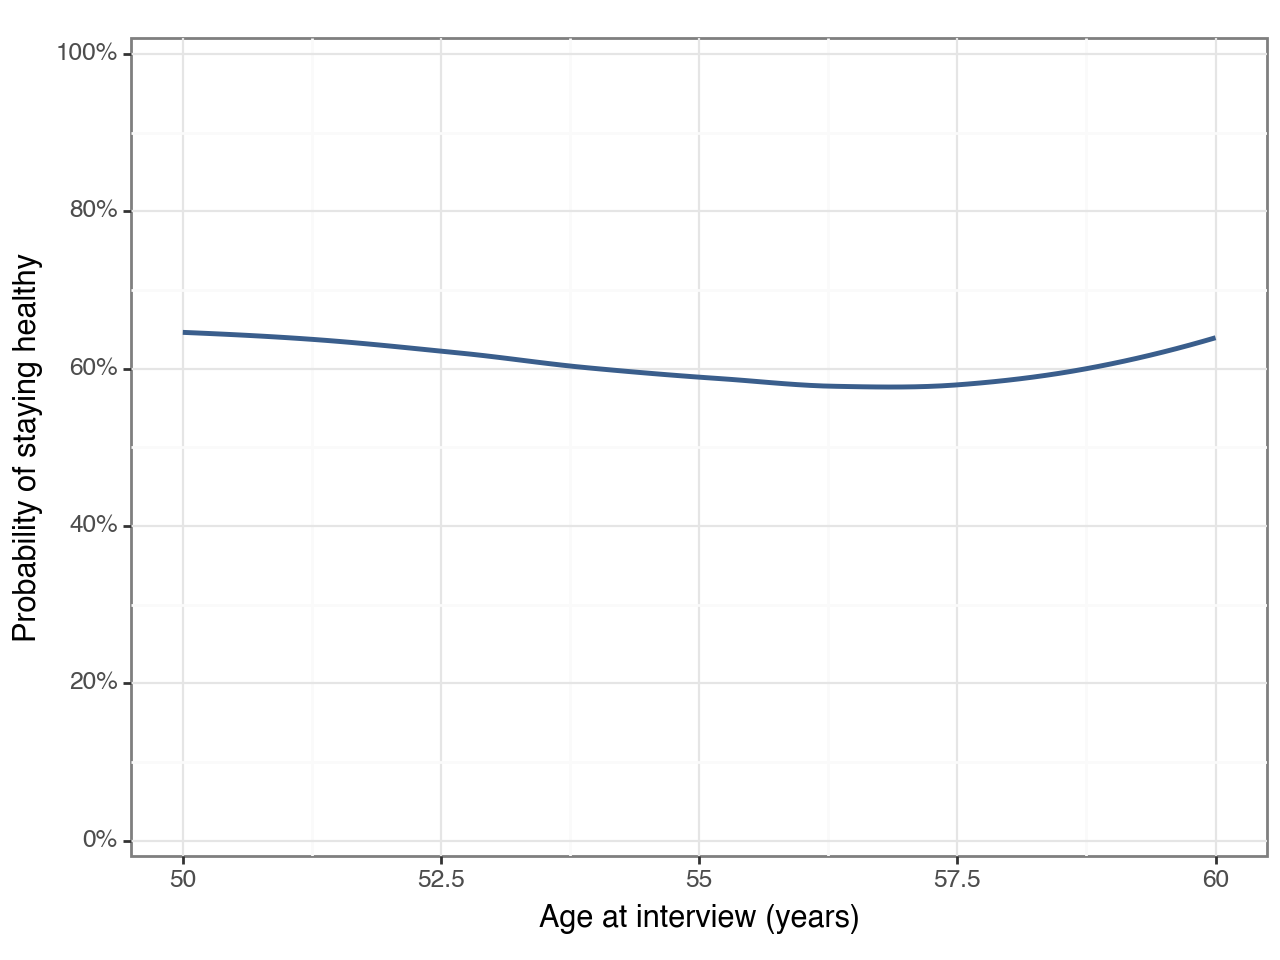

<Figure Size: (640 x 480)>

In [212]:
g2c = (
    ggplot(data=share)
    + geom_smooth(
        aes(x="age", y="stayshealthy"), method="loess", se=False, color=color[0]
    )
    + scale_y_continuous(
        expand=[0.01, 0.01],
        limits=[0, 1],
        breaks=seq(0, 1, 0.2),
        labels=percent_format(),
    )
    + labs(x="Age at interview (years)", y="Probability of staying healthy")
    + theme_bw()
)
g2c


Looks close to linear

Not in the book

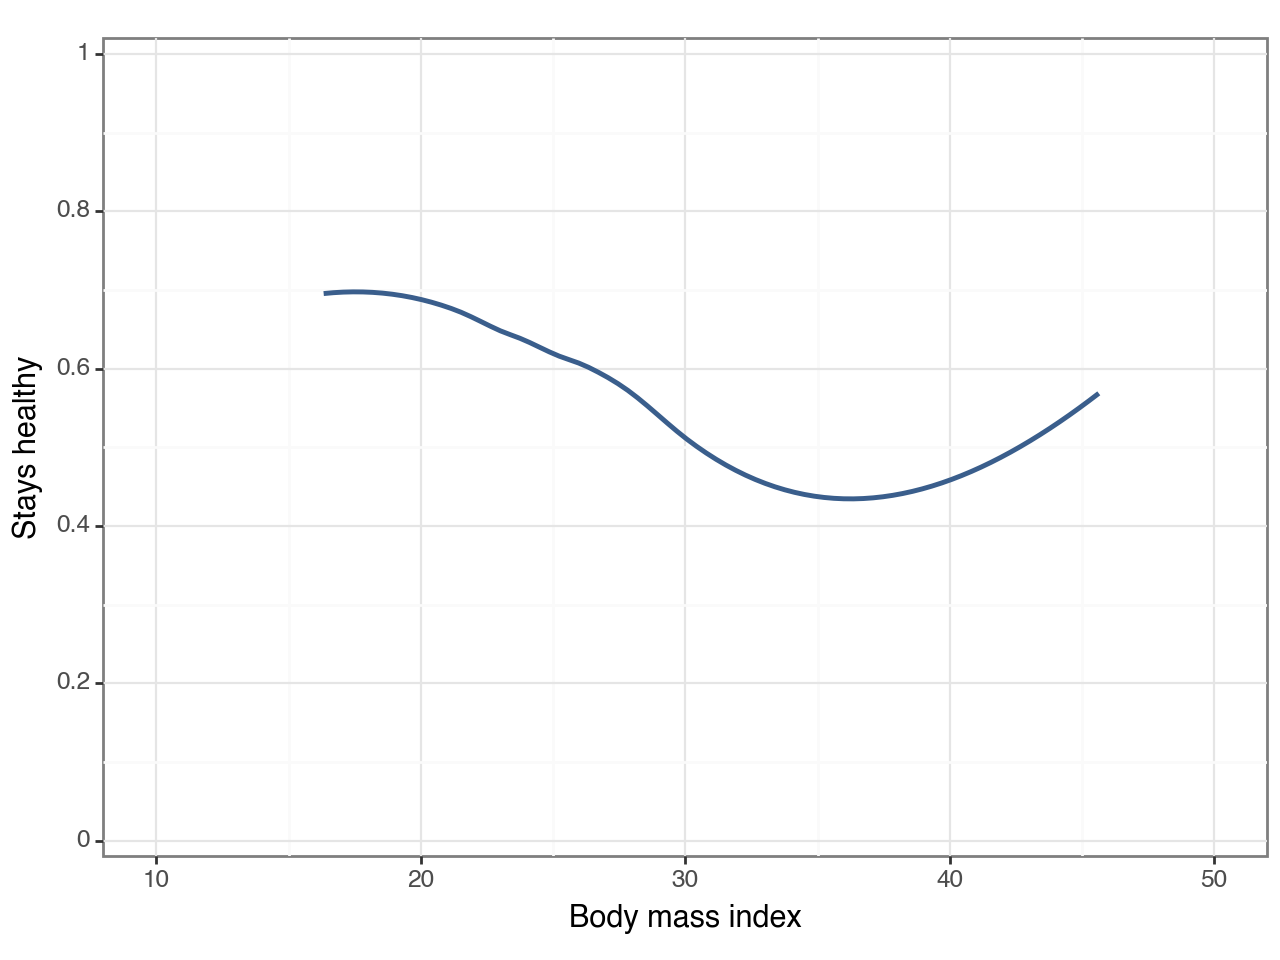

<Figure Size: (640 x 480)>

In [213]:
g2d = (
    ggplot(data=share)
    + geom_smooth(
        aes(x="bmi", y="stayshealthy"), method="loess", se=False, color=color[0]
    )
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 1], breaks=seq(0, 1, 0.2))
    + scale_x_continuous(limits=[10, 50], breaks=seq(10, 50, 10))
    + labs(x="Body mass index", y="Stays healthy")
    + theme_bw()
)
g2d


Knot at 35 (high value, showing obesity) -> piecewise linear spline

# 3. PART - PROBABILITY MODELS (LPM, LOGIT, PROBIT) & PREDICTION

country as categorical

In [109]:
share["country"] = share["country"].astype("category")


In [110]:
lpm3 = smf.ols(
    "stayshealthy ~ smoking + ever_smoked + female + age + lspline(eduyears,[8,18]) + \
                    income10 + lspline(bmi,[35]) + exerc + country",
    share,
).fit(covtype="HC1")


### Table 11.2 Smoking and the probability of staying healthy – rich LPM

In [111]:
stargazer = Stargazer([lpm3])
stargazer.covariate_order(
    [
        "smoking",
        "ever_smoked",
        "female",
        "age",
        "lspline(eduyears, [8, 18])[0]",
        "lspline(eduyears, [8, 18])[1]",
        "lspline(eduyears, [8, 18])[2]",
        "income10",
        "lspline(bmi, [35])[0]",
        "lspline(bmi, [35])[1]",
        "exerc",
    ]
)
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer.add_line("Country indicators", ["Yes"])
stargazer


**Model 3**: conditioning on other variables
- coefficient on smoking is -0.061 -> comparing people who live in the same country, have same gender, age, years of educ, bmi, exercising habits, and belong to same income group, those who smoke are 6pp points less likely to stay healthy 

-> statistically significant at 5%, 95% CI [-0.107,-0.014]: we can be 95% confident that the coefficient is different from 0 in the population and it is in the range given by the CI


- coefficient on ever smoked is not statistically significant, there is a positive association in our data but we cannot say there is in the population

- coefficient on female: conditioning on other characteristics included in the regression, women are 3.3pp more likely to stay in good health

- age does not matter (restricted range 50-60)

- differences in years of educ comparing people with less than 8 or more than 18 years do not matter, they do a lot in between: someone with 18 years of education is 17pp more likely to stay healthy than someone with 8 years of educ, and all other characteristics included constant

- ...

In [216]:
#lpm3.conf_int(alpha=0.05)

In [218]:
share["pred_lpm"] = lpm3.predict()


In [219]:
share["pred_lpm"].describe().round(4)


count    3109.0000
mean        0.6047
std         0.1567
min         0.0361
25%         0.5001
50%         0.6073
75%         0.7134
max         1.0110
Name: pred_lpm, dtype: float64

note: max>1, but just marginally

### Figure 11.3 Histogram of the predicted probabilities

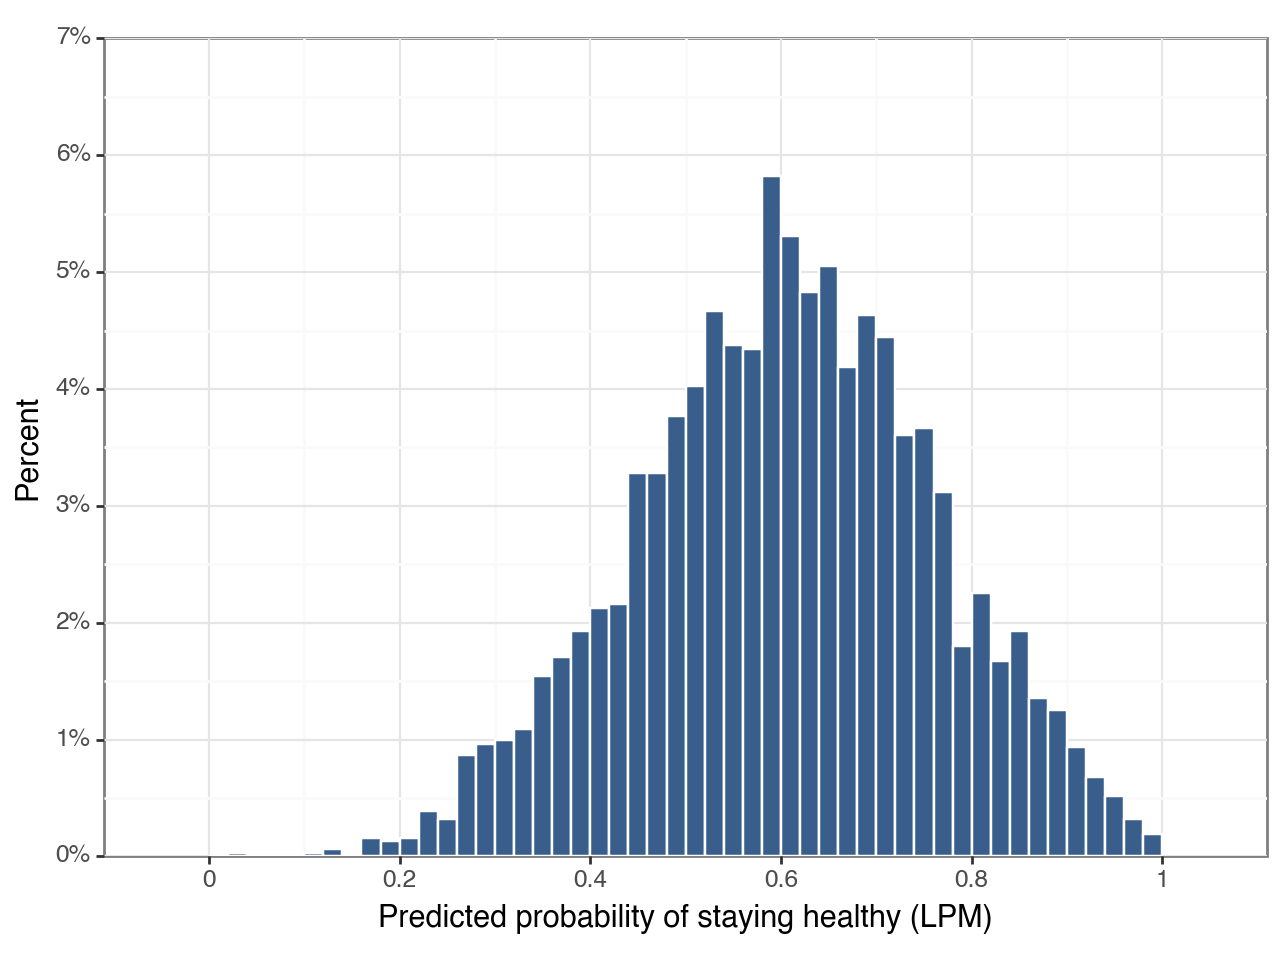

<Figure Size: (640 x 480)>

In [220]:
g3 = (
    ggplot(share, aes(x="pred_lpm"))
    + geom_histogram(
        aes(y="stat(count)/sum(stat(count))"),
        binwidth=0.02,
        center=0.65,
        color="white",
        fill=color[0],
        closed="right",
    )
    + labs(x="Predicted probability of staying healthy (LPM)", y="Percent")
    + scale_y_continuous(
        expand=[0.00, 0.0],
        limits=[0, 0.07],
        breaks=seq(0, 0.07, 0.01),
        labels=percent_format(),
    )
    + scale_x_continuous(expand=[0.1, 0.01], limits=[0, 1], breaks=seq(0, 1, 0.2))
    + theme_bw()
)
g3


Differences in predicted probabilities (of staying healthy) come from differences in the values of the explanatory variables in the regression

We want to look at the characteristics of the people in top 1% and bottom 1%

In [222]:
cuts = 100
share["q100_pred_lpm"] = pd.qcut(share["pred_lpm"], q=cuts, labels=range(1, cuts + 1))
#qcut() Quantile-based discretization function.
share["q100_pred_lpm"]

0       62
1       72
2       82
3       73
4       48
        ..
3104    31
3105    54
3106    29
3107    27
3108    30
Name: q100_pred_lpm, Length: 3109, dtype: category
Categories (100, int64): [1 < 2 < 3 < 4 ... 97 < 98 < 99 < 100]

In [223]:
share.loc[
    share["q100_pred_lpm"] == 1,
    ["smoking", "ever_smoked", "female", "age", "eduyears", "income10", "bmi", "exerc"],
].describe().round(1)

# Bottom 1%


,smoking,ever_smoked,female,age,eduyears,income10,bmi,exerc
count,32.0,32.0,32.0,32.0,32.0,32.0,32.0,32.0
mean,0.4,0.5,0.4,56.0,7.7,3.8,30.5,0.2
std,0.5,0.5,0.5,2.6,3.3,2.8,3.9,0.4
min,0.0,0.0,0.0,50.4,0.0,1.0,23.0,0.0
25%,0.0,0.0,0.0,53.9,4.8,1.0,28.1,0.0
50%,0.0,0.0,0.0,56.5,8.0,3.0,30.5,0.0
75%,1.0,1.0,1.0,57.8,10.2,6.2,33.9,0.0
max,1.0,1.0,1.0,59.9,14.0,10.0,38.1,1.0


- 40% current smokers
- 60% males
- av 7.7 years of educ
- av 30.5 bmi
- av lower income group
- 20% of them exercises

In [224]:
share.loc[
    share["q100_pred_lpm"] == 100,
    ["smoking", "ever_smoked", "female", "age", "eduyears", "income10", "bmi", "exerc"],
].describe().round(1)

# Top 1%


,smoking,ever_smoked,female,age,eduyears,income10,bmi,exerc
count,32.0,32.0,32.0,32.0,32.0,32.0,32.0,32.0
mean,0.0,0.4,1.0,53.9,17.3,8.9,20.8,0.9
std,0.0,0.5,0.2,2.5,1.5,1.6,1.8,0.3
min,0.0,0.0,0.0,50.6,13.0,4.0,17.2,0.0
25%,0.0,0.0,1.0,52.1,16.0,8.8,19.7,1.0
50%,0.0,0.0,1.0,53.4,17.5,10.0,20.8,1.0
75%,0.0,1.0,1.0,55.2,18.0,10.0,22.1,1.0
max,0.0,1.0,1.0,60.0,20.0,10.0,24.5,1.0


- no current smokers
- all women
- av 17.3 years of educ 
- av 20.7 bmi
- av high income group
- 90% of them exercise

# 4. PART - LOGIT VS. PROBIT MODELS

In [118]:
y, X = dmatrices(
    "stayshealthy ~ smoking + ever_smoked + female + age + lspline(eduyears,[8,18]) + \
                 income10 + lspline(bmi,[35]) + exerc + country",
    share,
)

logit = sm.GLM(y, X, family=sm.families.Binomial(link=sm.genmod.families.links.logit()))
logit = logit.fit()


In [119]:
logit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           stayshealthy   No. Observations:                 3109
Model:                            GLM   Df Residuals:                     3084
Model Family:                Binomial   Df Model:                           24
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1918.8
Date:                Sat, 02 Dec 2023   Deviance:                       3837.5
Time:                        11:25:29   Pearson chi2:                 3.12e+03
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1022
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         2.2781      0.885      2.573      0.010       0.543       4.013
country[T.12]                    -0.9828      0.330     -2.978      0.003      -1.630      -0.336
country[T.13]                    -0.1972      0.276     -0.714      0.475      -0.739       0.344
country[T.15]                    -0.6560      0.194     -3.382      0.001      -1.036      -0.276
country[T.16]                    -1.1196      0.185     -6.051      0.000      -1.482      -0.757
country[T.17]                    -0.7850      0.169     -4.640      0.000      -1.116      -0.453
country[T.18]                     0.4358      0.181      2.411      0.016       0.082       0.790
country[T.20]                     0.0679      0.159      0.426      0.670      -0.244       0.380
country[T.23]                    -0.5734      0.157     -3.650      0.000      -0.881      -0.265
country[T.28]                    -0.7552      0.176     -4.297      0.000      -1.100      -0.411
country[T.29]                    -1.4707      0.395     -3.719      0.000      -2.246      -0.696
country[T.33]                    -1.5783      0.301     -5.243      0.000      -2.168      -0.988
country[T.34]                    -0.9203      0.205     -4.482      0.000      -1.323      -0.518
country[T.35]                    -1.3535      0.211     -6.416      0.000      -1.767      -0.940
smoking                          -0.2840      0.109     -2.601      0.009      -0.498      -0.070
ever_smoked                       0.0782      0.092      0.849      0.396      -0.102       0.259
female                            0.1608      0.082      1.964      0.050       0.000       0.321
age                              -0.0123      0.014     -0.859      0.391      -0.040       0.016
lspline(eduyears, [8, 18])[0]    -0.0030      0.033     -0.090      0.928      -0.068       0.062
lspline(eduyears, [8, 18])[1]     0.0791      0.016      5.022      0.000       0.048       0.110
lspline(eduyears, [8, 18])[2]    -0.0457      0.055     -0.825      0.410      -0.154       0.063
income10                          0.0356      0.015      2.452      0.014       0.007       0.064
lspline(bmi, [35])[0]            -0.0575      0.011     -5.033      0.000      -0.080      -0.035
lspline(bmi, [35])[1]             0.0311      0.071      0.439      0.661      -0.108       0.170
exerc                             0.2548      0.079      3.229      0.001       0.100       0.410
=================================================================================================
"""

In [120]:
share["pred_logit"] = logit.predict()


In [121]:
share["pred_logit"].describe()


count    3109.000000
mean        0.604696
std         0.157277
min         0.107760
25%         0.496971
50%         0.614335
75%         0.723092
max         0.920142
Name: pred_logit, dtype: float64

In [122]:
logit = sm.Logit(y, X)


In [123]:
logit_result = logit.fit()


Optimization terminated successfully.
         Current function value: 0.617166
         Iterations 5


In [124]:
logit_result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           stayshealthy   No. Observations:                 3109
Model:                          Logit   Df Residuals:                     3084
Method:                           MLE   Df Model:                           24
Date:                Sat, 02 Dec 2023   Pseudo R-squ.:                 0.08031
Time:                        11:25:33   Log-Likelihood:                -1918.8
converged:                       True   LL-Null:                       -2086.3
Covariance Type:            nonrobust   LLR p-value:                 1.329e-56
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         2.2781      0.885      2.573      0.010       0.543       4.013
country[T.12]                    -0.9828      0.330     -2.978      0.003      -1.630      -0.336
country[T.13]                    -0.1972      0.276     -0.714      0.475      -0.739       0.344
country[T.15]                    -0.6560      0.194     -3.382      0.001      -1.036      -0.276
country[T.16]                    -1.1196      0.185     -6.051      0.000      -1.482      -0.757
country[T.17]                    -0.7850      0.169     -4.640      0.000      -1.116      -0.453
country[T.18]                     0.4358      0.181      2.411      0.016       0.082       0.790
country[T.20]                     0.0679      0.159      0.426      0.670      -0.244       0.380
country[T.23]                    -0.5734      0.157     -3.650      0.000      -0.881      -0.265
country[T.28]                    -0.7552      0.176     -4.297      0.000      -1.100      -0.411
country[T.29]                    -1.4707      0.395     -3.719      0.000      -2.246      -0.696
country[T.33]                    -1.5783      0.301     -5.243      0.000      -2.168      -0.988
country[T.34]                    -0.9203      0.205     -4.482      0.000      -1.323      -0.518
country[T.35]                    -1.3535      0.211     -6.416      0.000      -1.767      -0.940
smoking                          -0.2840      0.109     -2.601      0.009      -0.498      -0.070
ever_smoked                       0.0782      0.092      0.849      0.396      -0.102       0.259
female                            0.1608      0.082      1.964      0.050       0.000       0.321
age                              -0.0123      0.014     -0.859      0.391      -0.040       0.016
lspline(eduyears, [8, 18])[0]    -0.0030      0.033     -0.090      0.928      -0.068       0.062
lspline(eduyears, [8, 18])[1]     0.0791      0.016      5.022      0.000       0.048       0.110
lspline(eduyears, [8, 18])[2]    -0.0457      0.055     -0.825      0.410      -0.154       0.063
income10                          0.0356      0.015      2.452      0.014       0.007       0.064
lspline(bmi, [35])[0]            -0.0575      0.011     -5.033      0.000      -0.080      -0.035
lspline(bmi, [35])[1]             0.0311      0.071      0.439      0.661      -0.108       0.170
exerc                             0.2548      0.079      3.229      0.001       0.100       0.410
=================================================================================================
"""

In [125]:
logit_margef_results = logit_result.get_margeff()


In [126]:
logit_margef_results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:           stayshealthy
Method:                          dydx
At:                           overall
=================================================================================================
                                   dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
country[T.12]                    -0.2106      0.070     -2.993      0.003      -0.349      -0.073
country[T.13]                    -0.0423      0.059     -0.714      0.475      -0.158       0.074
country[T.15]                    -0.1406      0.041     -3.406      0.001      -0.221      -0.060
country[T.16]                    -0.2399      0.039     -6.191      0.000      -0.316      -0.164
country[T.17]                    -0.1682      0.036     -4.701      0.000      -0.238      -0.098
country[T.18]                     0.0934      0.039      2.417      0.016       0.018       0.169
country[T.20]                     0.0146      0.034      0.427      0.670      -0.052       0.081
country[T.23]                    -0.1229      0.033     -3.678      0.000      -0.188      -0.057
country[T.28]                    -0.1618      0.037     -4.345      0.000      -0.235      -0.089
country[T.29]                    -0.3152      0.084     -3.751      0.000      -0.480      -0.150
country[T.33]                    -0.3382      0.063     -5.332      0.000      -0.463      -0.214
country[T.34]                    -0.1972      0.043     -4.538      0.000      -0.282      -0.112
country[T.35]                    -0.2901      0.044     -6.582      0.000      -0.376      -0.204
smoking                          -0.0609      0.023     -2.611      0.009      -0.107      -0.015
ever_smoked                       0.0168      0.020      0.849      0.396      -0.022       0.055
female                            0.0345      0.018      1.968      0.049       0.000       0.069
age                              -0.0026      0.003     -0.859      0.390      -0.009       0.003
lspline(eduyears, [8, 18])[0]    -0.0006      0.007     -0.090      0.928      -0.015       0.013
lspline(eduyears, [8, 18])[1]     0.0170      0.003      5.097      0.000       0.010       0.023
lspline(eduyears, [8, 18])[2]    -0.0098      0.012     -0.825      0.409      -0.033       0.013
income10                          0.0076      0.003      2.461      0.014       0.002       0.014
lspline(bmi, [35])[0]            -0.0123      0.002     -5.109      0.000      -0.017      -0.008
lspline(bmi, [35])[1]             0.0067      0.015      0.439      0.661      -0.023       0.036
exerc                             0.0546      0.017      3.248      0.001       0.022       0.088
=================================================================================================
"""

In [127]:
probit = sm.Probit(y, X)


In [128]:
probit_result = probit.fit()


Optimization terminated successfully.
         Current function value: 0.617255
         Iterations 5


In [129]:
probit_result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:           stayshealthy   No. Observations:                 3109
Model:                         Probit   Df Residuals:                     3084
Method:                           MLE   Df Model:                           24
Date:                Sat, 02 Dec 2023   Pseudo R-squ.:                 0.08018
Time:                        11:25:35   Log-Likelihood:                -1919.0
converged:                       True   LL-Null:                       -2086.3
Covariance Type:            nonrobust   LLR p-value:                 1.722e-56
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         1.4340      0.540      2.656      0.008       0.376       2.492
country[T.12]                    -0.5952      0.203     -2.926      0.003      -0.994      -0.197
country[T.13]                    -0.1128      0.166     -0.678      0.498      -0.439       0.213
country[T.15]                    -0.4007      0.119     -3.368      0.001      -0.634      -0.167
country[T.16]                    -0.6872      0.113     -6.082      0.000      -0.909      -0.466
country[T.17]                    -0.4761      0.103     -4.615      0.000      -0.678      -0.274
country[T.18]                     0.2573      0.105      2.440      0.015       0.051       0.464
country[T.20]                     0.0425      0.096      0.445      0.657      -0.145       0.230
country[T.23]                    -0.3450      0.095     -3.622      0.000      -0.532      -0.158
country[T.28]                    -0.4579      0.108     -4.252      0.000      -0.669      -0.247
country[T.29]                    -0.8784      0.235     -3.740      0.000      -1.339      -0.418
country[T.33]                    -0.9741      0.182     -5.359      0.000      -1.330      -0.618
country[T.34]                    -0.5592      0.126     -4.426      0.000      -0.807      -0.312
country[T.35]                    -0.8280      0.129     -6.407      0.000      -1.081      -0.575
smoking                          -0.1705      0.066     -2.568      0.010      -0.301      -0.040
ever_smoked                       0.0443      0.056      0.793      0.428      -0.065       0.154
female                            0.0973      0.050      1.953      0.051      -0.000       0.195
age                              -0.0083      0.009     -0.955      0.339      -0.025       0.009
lspline(eduyears, [8, 18])[0]    -0.0021      0.020     -0.102      0.918      -0.041       0.037
lspline(eduyears, [8, 18])[1]     0.0478      0.010      5.015      0.000       0.029       0.066
lspline(eduyears, [8, 18])[2]    -0.0286      0.033     -0.864      0.388      -0.093       0.036
income10                          0.0216      0.009      2.446      0.014       0.004       0.039
lspline(bmi, [35])[0]            -0.0346      0.007     -5.002      0.000      -0.048      -0.021
lspline(bmi, [35])[1]             0.0169      0.044      0.388      0.698      -0.069       0.102
exerc                             0.1510      0.048      3.148      0.002       0.057       0.245
=================================================================================================
"""

In [130]:
share["pred_probit"] = probit_result.predict()


In [131]:
share["pred_probit"].describe()


count    3109.000000
mean        0.604763
std         0.156611
min         0.103114
25%         0.498824
50%         0.612903
75%         0.720459
max         0.930006
Name: pred_probit, dtype: float64

In [132]:
probit_margef_results = probit_result.get_margeff()


In [133]:
probit_margef_results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
       Probit Marginal Effects       
=====================================
Dep. Variable:           stayshealthy
Method:                          dydx
At:                           overall
=================================================================================================
                                   dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
country[T.12]                    -0.2096      0.071     -2.938      0.003      -0.349      -0.070
country[T.13]                    -0.0397      0.059     -0.678      0.498      -0.155       0.075
country[T.15]                    -0.1411      0.042     -3.386      0.001      -0.223      -0.059
country[T.16]                    -0.2420      0.039     -6.193      0.000      -0.319      -0.165
country[T.17]                    -0.1677      0.036     -4.662      0.000      -0.238      -0.097
country[T.18]                     0.0906      0.037      2.446      0.014       0.018       0.163
country[T.20]                     0.0150      0.034      0.445      0.656      -0.051       0.081
country[T.23]                    -0.1215      0.033     -3.643      0.000      -0.187      -0.056
country[T.28]                    -0.1613      0.038     -4.288      0.000      -0.235      -0.088
country[T.29]                    -0.3094      0.082     -3.764      0.000      -0.470      -0.148
country[T.33]                    -0.3430      0.063     -5.435      0.000      -0.467      -0.219
country[T.34]                    -0.1969      0.044     -4.468      0.000      -0.283      -0.111
country[T.35]                    -0.2916      0.045     -6.536      0.000      -0.379      -0.204
smoking                          -0.0601      0.023     -2.575      0.010      -0.106      -0.014
ever_smoked                       0.0156      0.020      0.793      0.428      -0.023       0.054
female                            0.0343      0.018      1.957      0.050   -5.49e-05       0.069
age                              -0.0029      0.003     -0.956      0.339      -0.009       0.003
lspline(eduyears, [8, 18])[0]    -0.0007      0.007     -0.102      0.918      -0.015       0.013
lspline(eduyears, [8, 18])[1]     0.0168      0.003      5.074      0.000       0.010       0.023
lspline(eduyears, [8, 18])[2]    -0.0101      0.012     -0.864      0.387      -0.033       0.013
income10                          0.0076      0.003      2.453      0.014       0.002       0.014
lspline(bmi, [35])[0]            -0.0122      0.002     -5.060      0.000      -0.017      -0.007
lspline(bmi, [35])[1]             0.0060      0.015      0.388      0.698      -0.024       0.036
exerc                             0.0532      0.017      3.161      0.002       0.020       0.086
=================================================================================================
"""

In [134]:
df_plot = pd.melt(
    share[["pred_lpm", "pred_logit", "pred_probit"]].rename(
        columns={"pred_logit": "Logit", "pred_probit": "Probit"}
    ),
    value_vars=["Logit", "Probit"],
    id_vars=["pred_lpm"],
).sort_values(by=["variable"], ascending=False)


### Figure 11.5 Predicted probabilities from three different models

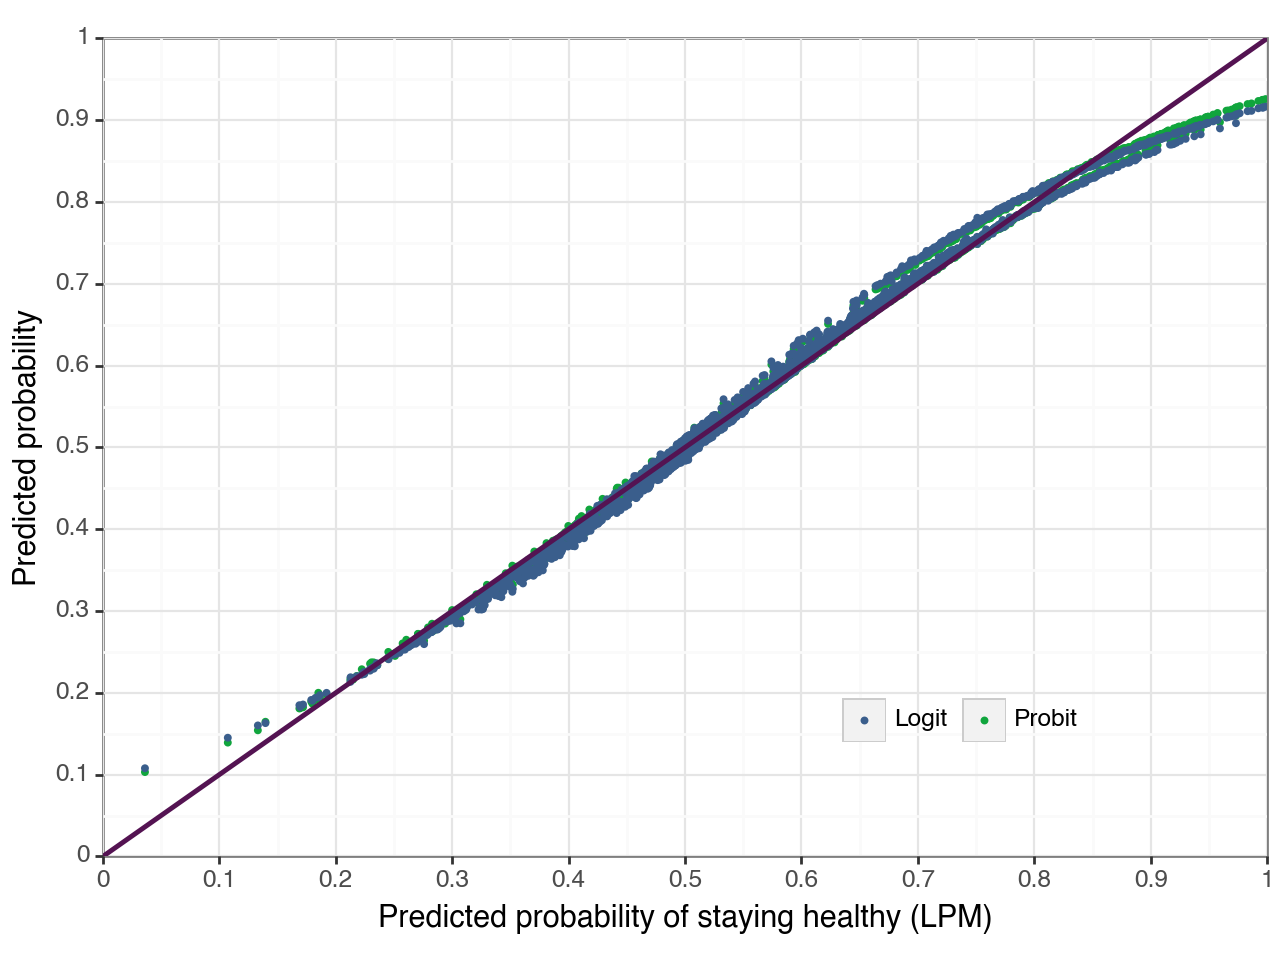

<Figure Size: (640 x 480)>

In [135]:
g5 = (
    ggplot(df_plot, aes(x="pred_lpm", y="value", color="variable"))
    + geom_point(size=0.6)
    + geom_abline(color=color[2], intercept=0, slope=1, size=1)
    + labs(
        x="Predicted probability of staying healthy (LPM)", y="Predicted probability"
    )
    + scale_y_continuous(expand=[0.00, 0.0], limits=[0, 1], breaks=seq(0, 1.1, 0.1))
    + scale_x_continuous(expand=[0.00, 0.0], limits=[0, 1], breaks=seq(0, 1.1, 0.1))
    + scale_color_manual(values=[color[0], color[1]])
    + theme_bw()
    + theme(
        legend_title=element_blank(),
        legend_direction="horizontal",
        legend_position=(0.75, 0.25),
        legend_background=element_blank(),
    )
)
g5

# Part 5 goodness of fit

In [136]:
lpmbase = smf.ols("stayshealthy ~ smoking", data=share).fit()


In [137]:
share["pred_lpmbase"] = lpmbase.predict()


### Figure 11.7 Staying healthy and the distribution of the predicted probability of staying healthy. Two linear probability model

(a) Simple LPM

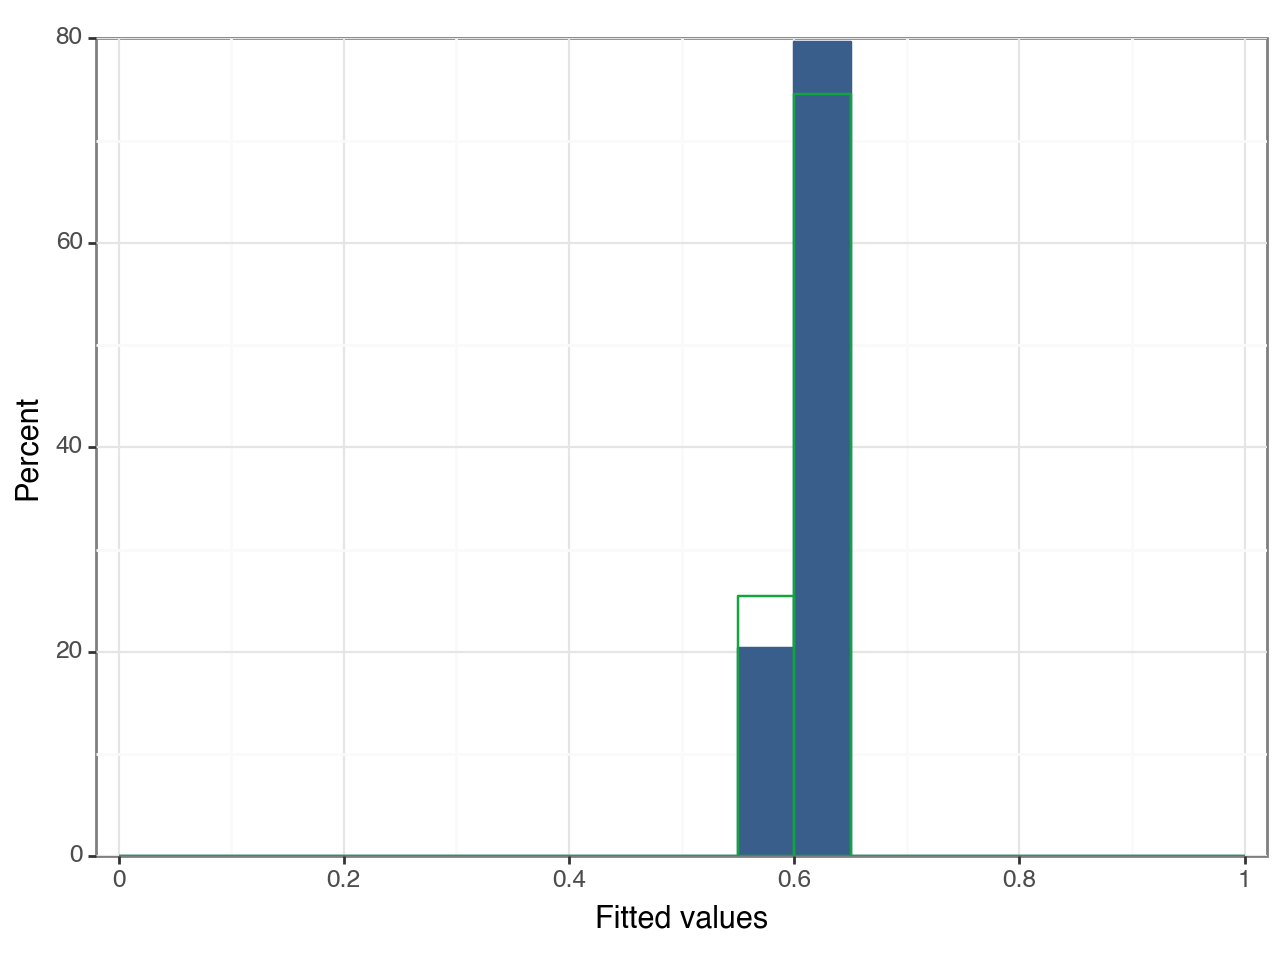

<Figure Size: (640 x 480)>

In [138]:
(
    ggplot(
        share,
        aes(x="pred_lpmbase", fill="stayshealthy", y="stat(count/sum(count)))*100"),
    )
    + geom_histogram(
        share[share["stayshealthy"] == 1],
        binwidth=0.05,
        color=color[0],
        fill=color[0],
        boundary=0.55,
    )
    + geom_histogram(
        share[share["stayshealthy"] == 0],
        binwidth=0.05,
        color=color[1],
        fill=None,
        boundary=0.55,
    )
    + ylab("Percent")
    + xlab("Fitted values")
    + scale_x_continuous(expand=[0.01, 0.01], limits=[0, 1], breaks=seq(0, 1.1, 0.2))
    + scale_y_continuous(expand=[0.00, 0.00], limits=[0, 80], breaks=seq(0, 81, 20))
    + theme_bw()
)

(b) Rich LPM

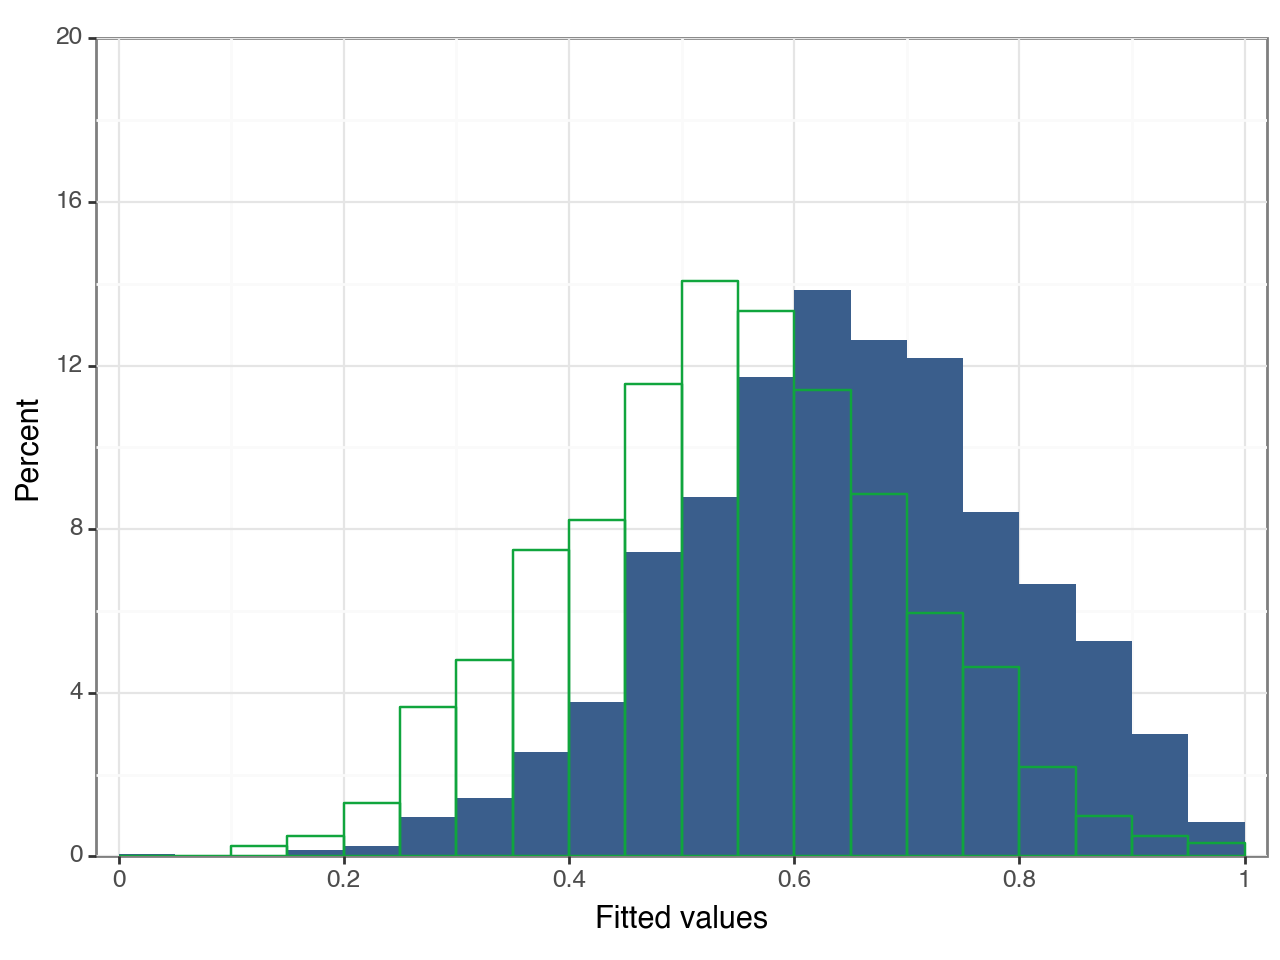

<Figure Size: (640 x 480)>

In [139]:
g7b = (
    ggplot(
        share,
        aes(x="pred_lpm", fill="stayshealthy", y="stat(count/sum(count)))*100"),
    )
    + geom_histogram(
        share[share["stayshealthy"] == 1],
        binwidth=0.05,
        # color="blue",
        fill=color[0],
        boundary=0.55,
    )
    + geom_histogram(
        share[share["stayshealthy"] == 0],
        binwidth=0.05,
        color=color[1],
        fill=None,
        boundary=0.55,
    )
    + ylab("Percent")
    + xlab("Fitted values")
    + scale_x_continuous(expand=[0.01, 0.01], limits=[0, 1], breaks=seq(0, 1.1, 0.2))
    + scale_y_continuous(expand=[0.00, 0.00], limits=[0, 20], breaks=seq(0, 21, 4))
    + theme_bw()
)
g7b


#### Table 11.4 Comparing probability models – mean and median

In [140]:
share.groupby("stayshealthy")[
    "pred_lpmbase", "pred_lpm", "pred_logit", "pred_probit"
].mean().round(3)


ValueError: Cannot subset columns with a tuple with more than one element. Use a list instead.

In [ ]:
share.groupby("stayshealthy")[
    "pred_lpmbase", "pred_lpm", "pred_logit", "pred_probit"
].median().round(3)


### Table 11.5 Statistics of goodness of fit for the probability predictions of three models

In [141]:
pd.DataFrame(
    {
        "R-squared": [
            lpm3.rsquared,
            r2_score(share["stayshealthy"], share["pred_logit"]),
            r2_score(share["stayshealthy"], share["pred_probit"]),
        ],
        "Brier-score": [
            mean_squared_error(share["stayshealthy"], share["pred_lpm"]),
            mean_squared_error(share["stayshealthy"], share["pred_logit"]),
            mean_squared_error(share["stayshealthy"], share["pred_probit"]),
        ],
        "Pseudo R-squared": [np.nan, logit_result.prsquared, probit_result.prsquared],
        "Log-loss": [
            -1 * log_loss(share["stayshealthy"], share["pred_lpm"]),
            -1 * log_loss(share["stayshealthy"], share["pred_logit"]),
            -1 * log_loss(share["stayshealthy"], share["pred_probit"]),
        ],
    },
    index=["LPM", "Logit", "Probit"],
).T.round(3)


,LPM,Logit,Probit
R-squared,0.103,0.104,0.104
Brier-score,0.215,0.214,0.214
Pseudo R-squared,NaN,0.080,0.080
Log-loss,-0.620,-0.617,-0.617


### Figure 11.8 Calibration curves for the predictions of the linear probability and logit models

(a) LPM

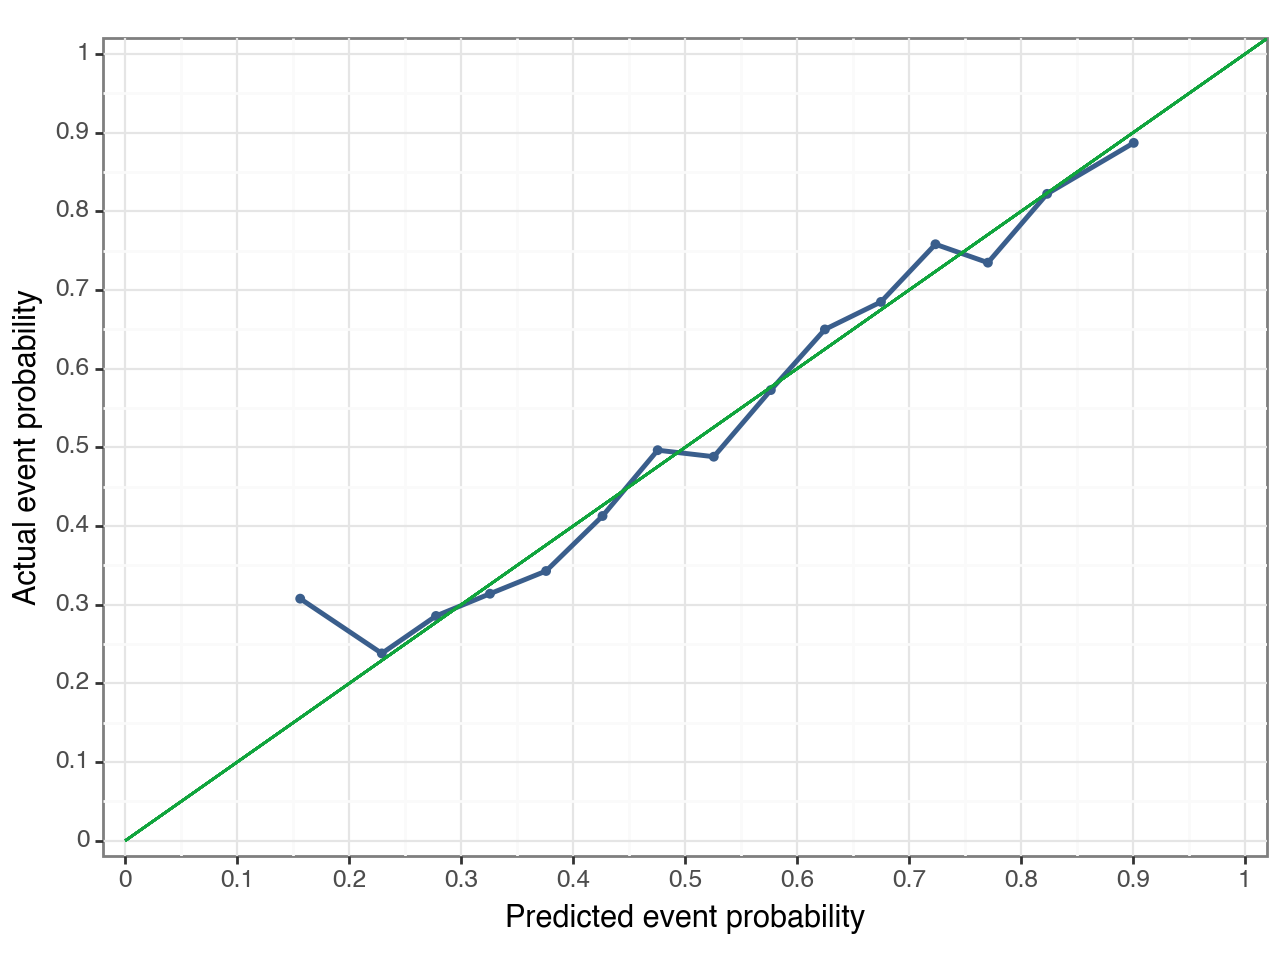

<Figure Size: (640 x 480)>

In [142]:
create_calibration_plot(
    share,
    file_name="ch11-figure-8b-calib-logit",
    prob_var="pred_lpm",
    actual_var="stayshealthy",
    breaks=np.array(
        [
            0,
            0.2,
            0.25,
            0.3,
            0.35,
            0.4,
            0.45,
            0.5,
            0.55,
            0.6,
            0.65,
            0.7,
            0.75,
            0.8,
            0.85,
            1.05,
        ]
    ),
)


(b) Logit

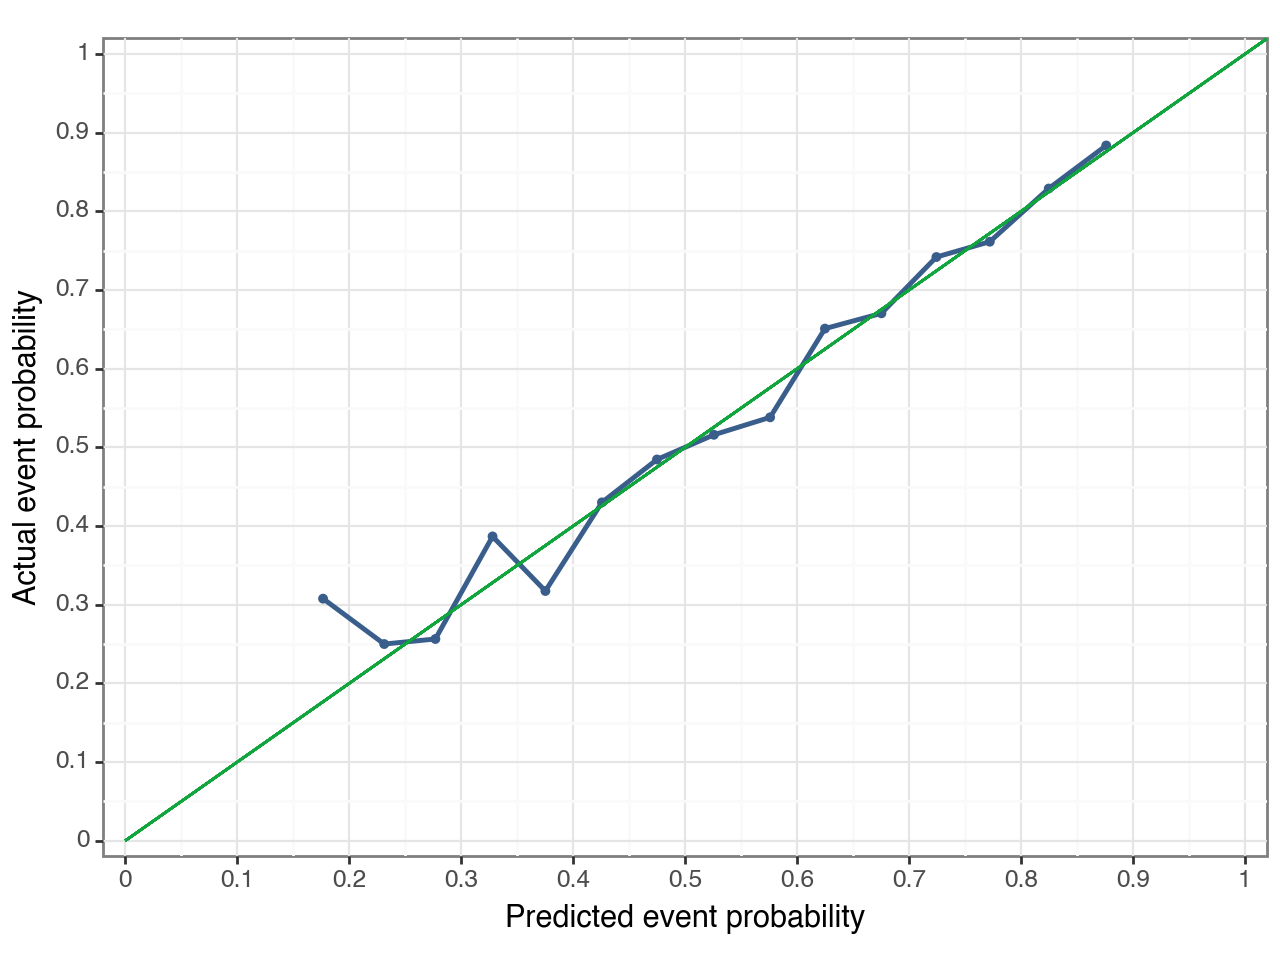

<Figure Size: (640 x 480)>

In [143]:
create_calibration_plot(
    share,
    file_name="ch11-figure-8b-calib-logit",
    prob_var="pred_logit",
    actual_var="stayshealthy",
    breaks=np.array(
        [
            0,
            0.2,
            0.25,
            0.3,
            0.35,
            0.4,
            0.45,
            0.5,
            0.55,
            0.6,
            0.65,
            0.7,
            0.75,
            0.8,
            0.85,
            1.05,
        ]
    ),
)


In [144]:
## Part 7


In [145]:
df = share[["pred_lpmbase", "pred_lpm", "pred_logit", "pred_probit"]].copy()


In [146]:
for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        if df.iloc[i, j] > 0.5:
            df.iloc[i, j] = 1
        else:
            df.iloc[i, j] = 0


In [147]:
pd.crosstab(df.iloc[:, 0], share["stayshealthy"], normalize="all")


stayshealthy,0.0,1.0
pred_lpmbase,,
1.0,0.395304,0.604696


In [148]:
for j in range(df.shape[1]):
    print(pd.crosstab(df.iloc[:, j], share["stayshealthy"], normalize="all"))
    print(pd.crosstab(df.iloc[:, j], share["stayshealthy"], normalize="columns"))


stayshealthy       0.0       1.0
pred_lpmbase                    
1.0           0.395304  0.604696
stayshealthy  0.0  1.0
pred_lpmbase          
1.0           1.0  1.0
stayshealthy       0.0       1.0
pred_lpm                        
0.0           0.149244  0.100675
1.0           0.246060  0.504021
stayshealthy       0.0       1.0
pred_lpm                        
0.0           0.377543  0.166489
1.0           0.622457  0.833511
stayshealthy       0.0       1.0
pred_logit                      
0.0           0.153104  0.101962
1.0           0.242200  0.502734
stayshealthy       0.0       1.0
pred_logit                      
0.0           0.387307  0.168617
1.0           0.612693  0.831383
stayshealthy       0.0       1.0
pred_probit                     
0.0           0.150209  0.101640
1.0           0.245095  0.503056
stayshealthy       0.0       1.0
pred_probit                     
0.0           0.379984  0.168085
1.0           0.620016  0.831915


## Figure 11.4 The logit and probit link functions

In [149]:
share = pd.read_csv(os.path.join(data_out, "ch11_share.csv"))


In [150]:
share["country"] = share["country"].astype("category")


In [151]:
y, X = dmatrices(
    "stayshealthy ~ smoking + ever_smoked + female + age + lspline(eduyears,[8,18]) + \
                 income10 + lspline(bmi,[35]) + exerc + country",
    share,
)


In [152]:
logit = sm.Logit(y, X).fit()


Optimization terminated successfully.
         Current function value: 0.617166
         Iterations 5


In [153]:
logit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           stayshealthy   No. Observations:                 3109
Model:                          Logit   Df Residuals:                     3084
Method:                           MLE   Df Model:                           24
Date:                Sat, 02 Dec 2023   Pseudo R-squ.:                 0.08031
Time:                        11:25:51   Log-Likelihood:                -1918.8
converged:                       True   LL-Null:                       -2086.3
Covariance Type:            nonrobust   LLR p-value:                 1.329e-56
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         2.2781      0.885      2.573      0.010       0.543       4.013
country[T.12]                    -0.9828      0.330     -2.978      0.003      -1.630      -0.336
country[T.13]                    -0.1972      0.276     -0.714      0.475      -0.739       0.344
country[T.15]                    -0.6560      0.194     -3.382      0.001      -1.036      -0.276
country[T.16]                    -1.1196      0.185     -6.051      0.000      -1.482      -0.757
country[T.17]                    -0.7850      0.169     -4.640      0.000      -1.116      -0.453
country[T.18]                     0.4358      0.181      2.411      0.016       0.082       0.790
country[T.20]                     0.0679      0.159      0.426      0.670      -0.244       0.380
country[T.23]                    -0.5734      0.157     -3.650      0.000      -0.881      -0.265
country[T.28]                    -0.7552      0.176     -4.297      0.000      -1.100      -0.411
country[T.29]                    -1.4707      0.395     -3.719      0.000      -2.246      -0.696
country[T.33]                    -1.5783      0.301     -5.243      0.000      -2.168      -0.988
country[T.34]                    -0.9203      0.205     -4.482      0.000      -1.323      -0.518
country[T.35]                    -1.3535      0.211     -6.416      0.000      -1.767      -0.940
smoking                          -0.2840      0.109     -2.601      0.009      -0.498      -0.070
ever_smoked                       0.0782      0.092      0.849      0.396      -0.102       0.259
female                            0.1608      0.082      1.964      0.050       0.000       0.321
age                              -0.0123      0.014     -0.859      0.391      -0.040       0.016
lspline(eduyears, [8, 18])[0]    -0.0030      0.033     -0.090      0.928      -0.068       0.062
lspline(eduyears, [8, 18])[1]     0.0791      0.016      5.022      0.000       0.048       0.110
lspline(eduyears, [8, 18])[2]    -0.0457      0.055     -0.825      0.410      -0.154       0.063
income10                          0.0356      0.015      2.452      0.014       0.007       0.064
lspline(bmi, [35])[0]            -0.0575      0.011     -5.033      0.000      -0.080      -0.035
lspline(bmi, [35])[1]             0.0311      0.071      0.439      0.661      -0.108       0.170
exerc                             0.2548      0.079      3.229      0.001       0.100       0.410
=================================================================================================
"""

In [154]:
share["bx_logit"] = np.asarray(X).dot(logit.params)


In [155]:
share["Logit"] = logistic.cdf(share["bx_logit"])


In [156]:
probit = sm.Probit(y, X).fit()


Optimization terminated successfully.
         Current function value: 0.617255
         Iterations 5


In [157]:
probit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:           stayshealthy   No. Observations:                 3109
Model:                         Probit   Df Residuals:                     3084
Method:                           MLE   Df Model:                           24
Date:                Sat, 02 Dec 2023   Pseudo R-squ.:                 0.08018
Time:                        11:25:52   Log-Likelihood:                -1919.0
converged:                       True   LL-Null:                       -2086.3
Covariance Type:            nonrobust   LLR p-value:                 1.722e-56
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         1.4340      0.540      2.656      0.008       0.376       2.492
country[T.12]                    -0.5952      0.203     -2.926      0.003      -0.994      -0.197
country[T.13]                    -0.1128      0.166     -0.678      0.498      -0.439       0.213
country[T.15]                    -0.4007      0.119     -3.368      0.001      -0.634      -0.167
country[T.16]                    -0.6872      0.113     -6.082      0.000      -0.909      -0.466
country[T.17]                    -0.4761      0.103     -4.615      0.000      -0.678      -0.274
country[T.18]                     0.2573      0.105      2.440      0.015       0.051       0.464
country[T.20]                     0.0425      0.096      0.445      0.657      -0.145       0.230
country[T.23]                    -0.3450      0.095     -3.622      0.000      -0.532      -0.158
country[T.28]                    -0.4579      0.108     -4.252      0.000      -0.669      -0.247
country[T.29]                    -0.8784      0.235     -3.740      0.000      -1.339      -0.418
country[T.33]                    -0.9741      0.182     -5.359      0.000      -1.330      -0.618
country[T.34]                    -0.5592      0.126     -4.426      0.000      -0.807      -0.312
country[T.35]                    -0.8280      0.129     -6.407      0.000      -1.081      -0.575
smoking                          -0.1705      0.066     -2.568      0.010      -0.301      -0.040
ever_smoked                       0.0443      0.056      0.793      0.428      -0.065       0.154
female                            0.0973      0.050      1.953      0.051      -0.000       0.195
age                              -0.0083      0.009     -0.955      0.339      -0.025       0.009
lspline(eduyears, [8, 18])[0]    -0.0021      0.020     -0.102      0.918      -0.041       0.037
lspline(eduyears, [8, 18])[1]     0.0478      0.010      5.015      0.000       0.029       0.066
lspline(eduyears, [8, 18])[2]    -0.0286      0.033     -0.864      0.388      -0.093       0.036
income10                          0.0216      0.009      2.446      0.014       0.004       0.039
lspline(bmi, [35])[0]            -0.0346      0.007     -5.002      0.000      -0.048      -0.021
lspline(bmi, [35])[1]             0.0169      0.044      0.388      0.698      -0.069       0.102
exerc                             0.1510      0.048      3.148      0.002       0.057       0.245
=================================================================================================
"""

In [158]:
share["bx_probit"] = np.asarray(X).dot(probit.params)


In [159]:
share["Probit"] = norm.cdf(share["bx_probit"])


In [160]:
share_plot = pd.melt(
    share[["bx_logit", "Logit", "Probit"]],
    id_vars=["bx_logit"],
    value_vars=["Logit", "Probit"],
)


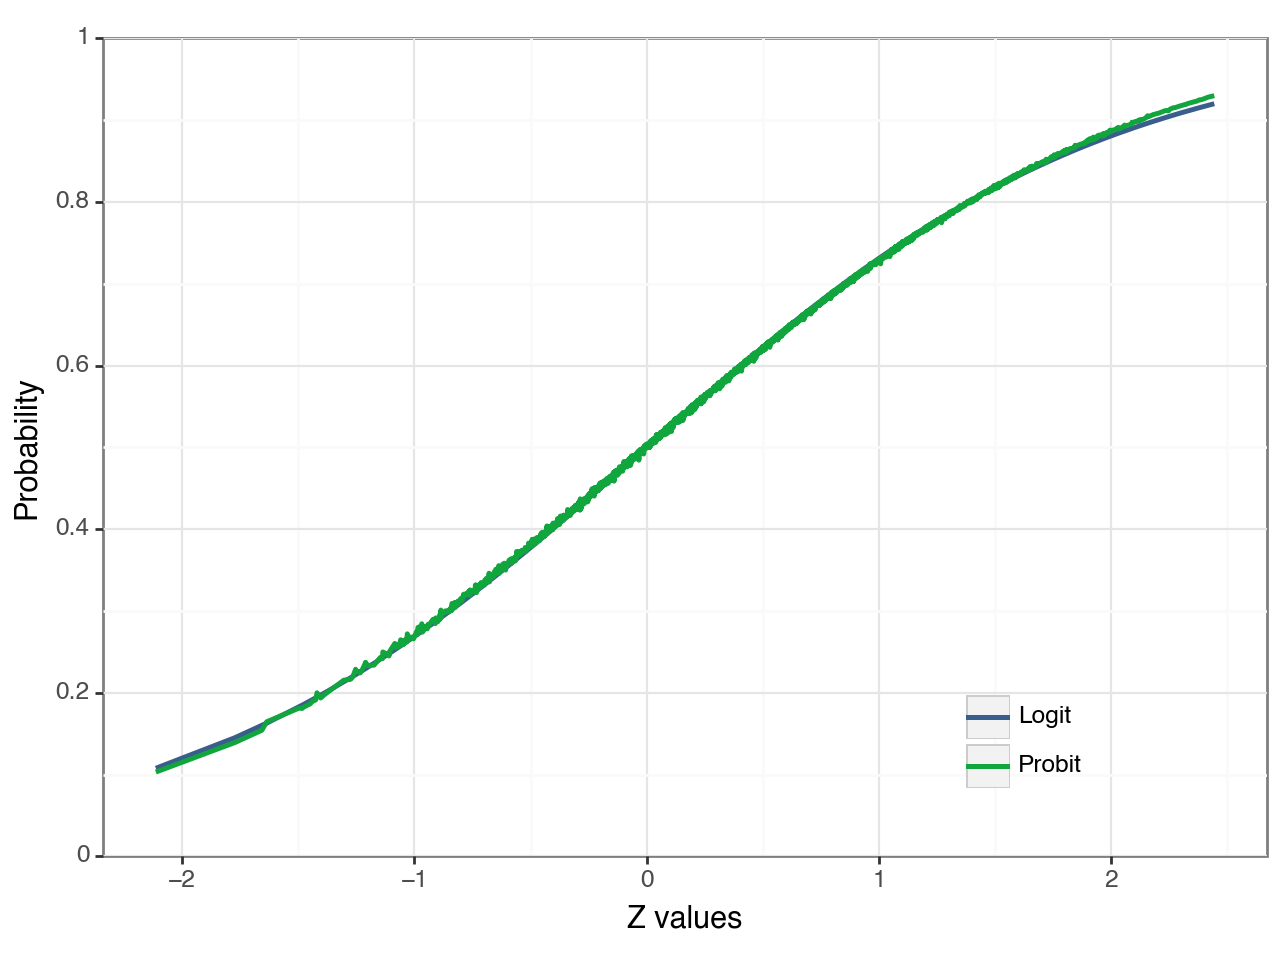

<Figure Size: (640 x 480)>

In [161]:
g4 = (
    ggplot(data=share_plot)
    + geom_line(aes(x="bx_logit", y="value", color="variable"), size=1)
    + ylab("Probability")
    + xlab("Z values")
    + scale_color_manual(values=color[0:2], name=" ", labels=("Logit", "Probit"))
    + scale_y_continuous(expand=[0.00, 0.00], limits=[0, 1], breaks=seq(0, 1.1, 0.2))
    + theme_bw()
    + theme(
        legend_position=(0.8, 0.25),
        legend_direction="vertical",
        legend_background=element_blank(),
    )
)
g4